In [1]:
from PrepareOriginalData import PrepareData
import numpy as np

# Some constants
taskType = 'all'
data_amount = 3000
epochs = 10

# Train on only one question type
question_type = 'all'

#use 6 and 3 for questions and answers!

# Load training set
p = PrepareData(path_images='data_vqa_feat', # Path to image features 
                subset='train2014', # Desired subset: either train2014 or val2014
                taskType='OpenEnded', # 'OpenEnded', 'MultipleChoice', 'all'
                cut_data=data_amount, # Percentage of data to use, 1 = All values, above 1=#samples for debugging
                output_path='data', # Path where we want to output temporary data
                pad_length=14, # Number of words in a question (zero padded)
                question_threshold=6, answer_threshold=3, # Keep only most common words #yes/no use 10
                questions_sparse=True, answer_type=question_type,
                image_extractor='RawImages')
image_features, questions, answers, annotations = p.load_data()
print("Image features", image_features.shape)
print("Question features", questions.shape)
print("Answers", answers.shape)
print("Dictionary size", p.dic_size)
print("Number of possible classes", np.max(answers) + 1)

# Save dictionary
p.dumpDictionary('dictionary_other')

Using TensorFlow backend.


loading VQA annotations and questions into memory...
0:00:04.236412
creating index...
index created!
Image features (3000, 1)
Question features (3000, 14)
Answers (3000, 126)
Dictionary size 1940
Number of possible classes 2.0


In [2]:
# Load Glove embedding
# load the whole embedding into memory
embeddings_index = dict()
f = open('data/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# Create an embedding matrix
embedding_matrix = np.zeros((np.max(questions) + 1, 100)) # Ignore thresholded words
for word in p._question_dict.keys():
    # If word was thresholded ignore it
    if p._question_dict[word] != 0:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[p._question_dict[word]] = embedding_vector
print(embedding_matrix.shape)

Loaded 400000 word vectors.
(347, 100)


In [3]:
# Load extracted features
import pickle
image_features = np.zeros((len(p._original_questions), 4, 4, 2048))
with open('data/attentions_train_1000.pkl', 'rb') as f:
    attentions = pickle.load(f)
    for i in range(len(p._original_questions)):
        image_features[i] = attentions[p._original_questions[i]['image_id']]

# Reshape
image_features = image_features.reshape((image_features.shape[0], 16, 2048))
print(image_features.shape)

(3000, 16, 2048)


In [22]:
from NeuralNetworkStateOfTheArtApproach import NeuralNetwork
neuralnet = NeuralNetwork(image_features.shape[0],2048,questions.shape[1],np.max(questions)+1,
                          embedding_matrix, answers.shape[1], epochs = epochs, batchSize=384,
                          loss='sparse_categorical_crossentropy', activation='softmax', monitor='val_acc')

#FOR TESTING
#import numpy as np
#image_features = np.random.rand(10,16,1024) #10 samples, 16 locations, 1000 dimensions
#questions = np.random.rand(10,100) #10 samples, 100 dimensions (embedding)
#answers = np.random.rand(10,100) #10 samples, 100 dimensions (answer classes)
#embedding_matrix = np.random.rand(32,100)

#neuralnet = NeuralNetwork(image_features.shape[0],1024,questions.shape[1], 32, embedding_matrix, np.max(answers)+1, epochs = 5, batchSize=384)

AttributeError: 'list' object has no attribute 'shape'

In [13]:
# Train network
neuralnet.fit(image_features, questions, answers)

(3000, 16, 2048) (3000, 14) (3000, 126)
Train on 2100 samples, validate on 900 samples
Epoch 1/10
2100/2100 [==============================] - 31s 15ms/step - loss: 4.7448 - acc: 0.2171 - val_loss: 4.7351 - val_acc: 0.2578
Epoch 2/10
2100/2100 [==============================] - 33s 16ms/step - loss: 4.7270 - acc: 0.2719 - val_loss: 4.7155 - val_acc: 0.2578
Epoch 3/10
2100/2100 [==============================] - 35s 17ms/step - loss: 4.7033 - acc: 0.2719 - val_loss: 4.6870 - val_acc: 0.2578
Epoch 4/10
2100/2100 [==============================] - 34s 16ms/step - loss: 4.6673 - acc: 0.2719 - val_loss: 4.6402 - val_acc: 0.2578
Epoch 5/10
2100/2100 [==============================] - 32s 15ms/step - loss: 4.6067 - acc: 0.2719 - val_loss: 4.5596 - val_acc: 0.2578
Epoch 6/10
2100/2100 [==============================] - 33s 16ms/step - loss: 4.5028 - acc: 0.2719 - val_loss: 4.4295 - val_acc: 0.2578
Epoch 7/10
2100/2100 [==============================] - 38s 18ms/step - loss: 4.3526 - acc: 0.271

In [14]:
#see what it predicts on training data, on which it trained!
pred = neuralnet.predict_current_state(image_features, questions)
print(pred)
print(answers)

[[ 0.0215402   1.          0.1568964  ...,  0.01587329  0.00333331
   0.00713058]
 [ 0.02194101  1.          0.15814853 ...,  0.01618999  0.00343451
   0.00729141]
 [ 0.02137535  1.          0.15641706 ...,  0.01574685  0.00329329
   0.00706608]
 ..., 
 [ 0.02140127  1.          0.16984655 ...,  0.0165972   0.00316353
   0.00656285]
 [ 0.02165402  1.          0.17059051 ...,  0.01681069  0.00322475
   0.00666204]
 [ 0.02087075  1.          0.16827208 ...,  0.01614626  0.00303542
   0.00635407]]
[[ 0.33333333  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          1.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          1.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          1.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          1.         ...,  0.          0.          0.        ]]


In [15]:
# Evaluate on training set
from EvaluateModel import ProduceResult
model_evaluator = ProduceResult(p._int_to_answer, p._answer_to_int, dataSubType='train2014')
model_evaluator.produce_results(pred, p._original_questions)
model_evaluator.evaluate(taskType='OpenEnded')

loading VQA annotations and questions into memory...
0:00:08.352050
creating index...
index created!
Loading and preparing results...     
DONE (t=0.01s)
creating index...
index created!
computing accuracy
Finshed Percent: [###################-] 96% Done computing accuracy


Overall Accuracy is: 27.63

Per Question Type Accuracy is the following:
what : 1.07
is there a : 92.13
is this : 68.73
is this a : 60.74
what color is the : 0.00
what is on the : 0.81
is the : 61.35
are these : 44.55
what is : 0.00
what is in the : 1.36
where is the : 2.25
what color are the : 1.33
where are the : 1.76
what animal is : 0.00
none of the above : 38.15
what kind of : 0.43
what is the : 0.38
are there any : 75.88
how : 9.09
what color is : 0.00
how many : 0.00
why is the : 14.62
who is : 1.76
is the person : 69.00
what color : 0.00
does this : 55.00
can you : 61.33
what is this : 0.00
does the : 76.00
is this person : 66.36
is : 87.69
which : 0.81
is the man : 58.13
what is the man : 0.91
are there : 

In [17]:
image_features = questions = answers = annotations = []
# question_type = 'all'
# Load validation set and evaluate prediction on it
pt= PrepareData(path_images='data_vqa_feat', # Path to image features 
                        subset='val2014', # Desired subset: either train2014 or val2014
                        taskType='all', # 'OpenEnded', 'MultipleChoice', 'all'
                        cut_data=data_amount, # Percentage of data to use, 1 = All values, above 1 = 10 samples for debugging
                        output_path='data', # Path where we want to output temporary data
                        pad_length=32, # Number of words in a question (zero padded)
                        question_threshold=6, answer_threshold=3, # Keep only most common words
                        questions_sparse=True, answer_type=question_type,
                        precomputed_dic=p._question_dict, image_extractor='RawImages')
pt.loadDictionary('data/dictionary_other.pkl') # Use same dictionary as in training
image_features, questions, answers, annotations = pt.load_data()
print("Image features", image_features.shape)
print("Question features", questions.shape)
print("Dictionary size", pt.dic_size)

loading VQA annotations and questions into memory...
0:00:03.645115
creating index...
index created!
loading VQA annotations and questions into memory...
0:00:02.951162
creating index...
index created!
Image features (6000, 1)
Question features (6000, 14)
Dictionary size 1940


In [18]:
# Load extracted features
import pickle
image_features = np.zeros((len(pt._original_questions), 4, 4, 2048))
with open('data/attentions_val_1000.pkl', 'rb') as f:
    attentions = pickle.load(f)
    for i in range(len(pt._original_questions)):
        image_features[i] = attentions[pt._original_questions[i]['image_id']]

# Reshape
image_features = image_features.reshape((image_features.shape[0], 16, 2048))
print(image_features.shape)

(6000, 16, 2048)


In [19]:
# Predict
pred = neuralnet.predict_current_state(image_features, questions)# 'weights/weights-60-0.5559.hdf5')
pred

array([[ 0.01862717,  1.        ,  0.15569922, ...,  0.01502297,
         0.00289666,  0.00651022],
       [ 0.01860885,  1.        ,  0.15561451, ...,  0.01500252,
         0.00289201,  0.0065016 ],
       [ 0.01855755,  1.        ,  0.15542263, ...,  0.01496053,
         0.00288064,  0.00648052],
       ..., 
       [ 0.02180446,  1.        ,  0.17064834, ...,  0.01688131,
         0.00337978,  0.0073761 ],
       [ 0.02133144,  1.        ,  0.16928661, ...,  0.01648305,
         0.00326288,  0.00717813],
       [ 0.02108453,  1.        ,  0.16857369, ...,  0.01627589,
         0.0032031 ,  0.00707527]], dtype=float32)

In [12]:
#average over multiple models
pred1 = pred2 = pred3 = pred4 = pred5 = pred6 = pred = []
pred1 = neuralnet.predict(image_features, questions, 'weights/weights-99-0.4507.hdf5')
pred1 += neuralnet.predict(image_features, questions, 'weights/weights-91-0.5499.hdf5')
pred1 += neuralnet.predict(image_features, questions, 'weights/weights-87-0.5516.hdf5')
pred1 += neuralnet.predict(image_features, questions, 'weights/weights-60-0.5559Other60epochs.hdf5')
pred1 += neuralnet.predict(image_features, questions, 'weights/weights-58-0.5690.hdf5')
pred1 += neuralnet.predict(image_features, questions, 'weights/weights-56-0.5697.hdf5')
pred1 /= 6

In [20]:
from EvaluateModel import ProduceResult
model_evaluator = ProduceResult(p._int_to_answer, p._answer_to_int, dataSubType='val2014')
answers = model_evaluator.produce_results(pred, pt._original_questions)
model_evaluator.evaluate(taskType=taskType)

loading VQA annotations and questions into memory...
0:00:06.341875
creating index...
index created!
Loading and preparing results...     
DONE (t=0.01s)
creating index...
index created!
computing accuracy
Finshed Percent: [###################-] 96% Done computing accuracy


Overall Accuracy is: 26.73

Per Question Type Accuracy is the following:
what is the : 0.63
is the : 60.13
what : 0.94
is this an : 65.56
are there : 84.00
what is in the : 1.03
is it : 66.11
what is : 0.00
how many : 0.77
is this : 58.57
is there a : 82.41
is the person : 58.13
is this a : 56.51
what color is the : 0.16
how : 4.29
do : 60.00
how many people are in : 0.00
why : 8.08
are the : 57.89
none of the above : 31.74
are : 45.14
does this : 72.94
what is the person : 2.50
what are : 0.00
who is : 0.00
what brand : 0.00
has : 80.91
what kind of : 0.68
is the man : 85.36
are they : 59.29
what type of : 0.61
is : 66.00
is this person : 50.91
what is the man : 0.00
are these : 59.80
how many people are : 1.25
wh

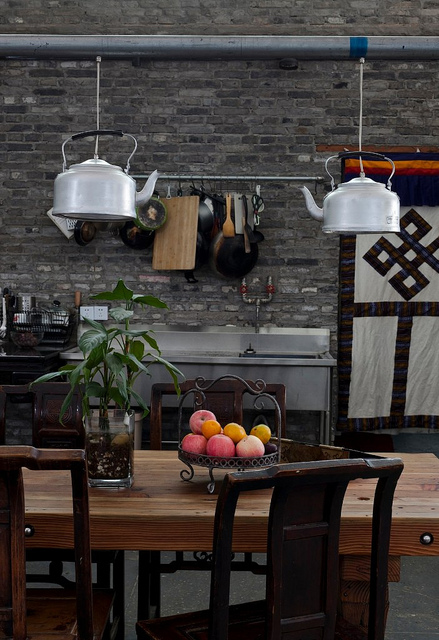

What is the table made of??
yes: 1.0; no: 1.0; 2: 0.995638; 
Ground truth: wood
[{'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'wood', 'answer_confidence': 'maybe', 'answer_id': 8}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 10}]


Is the food napping on the table??
yes: 1.0; no: 1.0; 2: 0.995645; 
Ground truth: no
[{'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 3}, {'

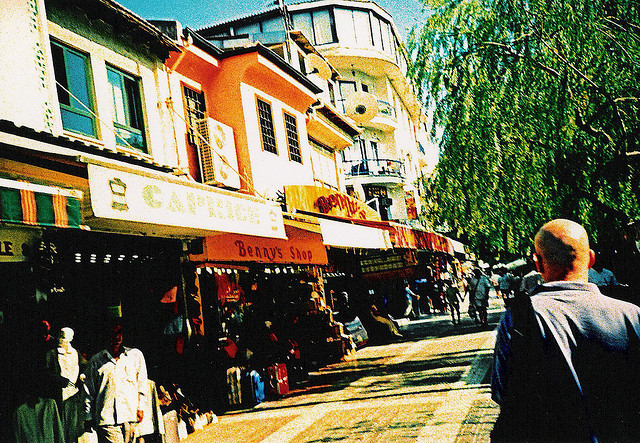

Is this an Spanish town??
yes: 1.0; no: 1.0; 2: 0.995253; 
Ground truth: no
[{'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 1}, {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 2}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 4}, {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 5}, {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 6}, {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 7}, {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 8}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 10}]


Are there shadows on the sidewalk??
yes: 1.0; no: 1.0; 2: 0.995376; 
Ground truth: yes
[{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 3}, {'a

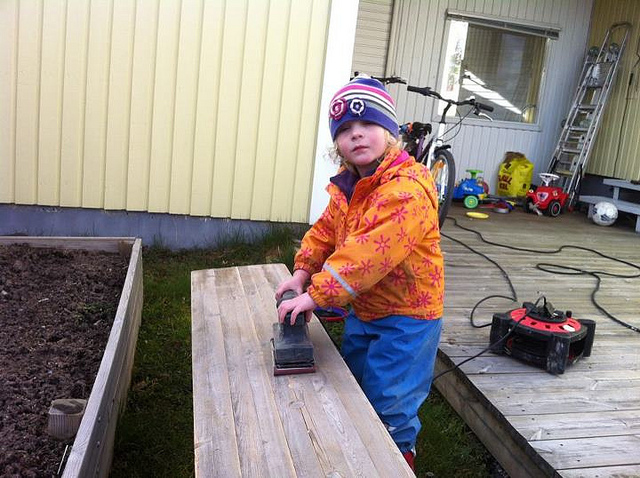

Is it cold outside??
no: 1.0; yes: 1.0; 2: 0.995589; 
Ground truth: yes
[{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 4}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 10}]


What is leaning against the house??
no: 1.0; yes: 1.0; 2: 0.995705; 
Ground truth: ladder
[{'answer': 'ladder', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'ladder', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'ladder', 'answer_confidence': 'yes', 'answer_id': 3}, {'a

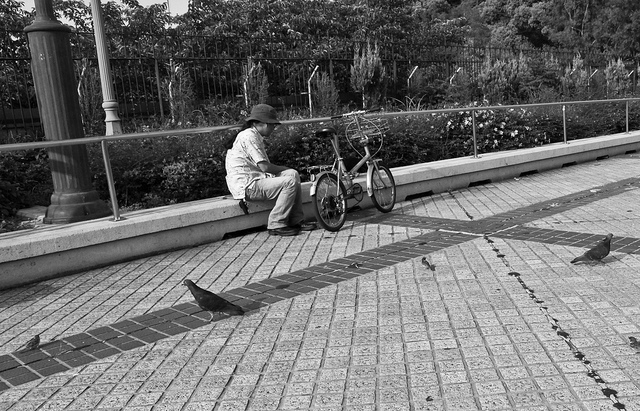

Is this in a park??
yes: 1.0; no: 1.0; 2: 0.995047; 
Ground truth: yes
[{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 9}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 10}]


Is there a bicycle in this picture??
yes: 1.0; no: 1.0; 2: 0.995177; 
Ground truth: yes
[{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'yes',

In [21]:
# Visualize prediction
from IPython.display import Image,display

def visualize_image_question_answer(index):
    if index % 3 == 0:
        subset_path = 'VQA/Images/mscoco/' + pt.subset + '/'
        image_path = subset_path + 'COCO_' + pt.subset + '_'+ str(annotations[index]["image_id"]).zfill(12) + '.jpg'
        display(Image(image_path,width=300))
        
    print(pt._original_questions[index]["question"] + '?')
    print(answers[index])
    print('Ground truth:', annotations[index]['multiple_choice_answer'])
    print(annotations[index]['answers'])
    print('\n')
    
for i in range(0,12):
    visualize_image_question_answer(i)